## 0. Set up

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import datetime
from functools import partial
from glob import glob
import math
import multiprocessing
from pathlib import Path
import random
from typing import Any, Dict, Optional
from tqdm.auto import tqdm


import torch
import torchvision
from torch.amp import autocast # allows for differentr datatypes (torch.32/ torch.16)
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks





import imageio.v3 as iio
import ipympl
import skimage as ski

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN, maskrcnn_resnet50_fpn
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights, MaskRCNN_ResNet50_FPN_Weights

In [2]:
device = get_torch_device()
dtype = torch.float32
torch.cuda.empty_cache()

In [3]:
# set up projects's directory
# project's name
project_name = f"pytorch-buildings-maskrcnn"

# path for project's folder
project_dir = Path(f"/{project_name}/")

# create the project directory
project_dir.mkdir(parents=True, exist_ok=True)

## 1. LOAD DATA

In [4]:
idx = 21

### 1.1 Load images

In [5]:
## Load images

images_dir = "C:/Users/kubaw/Desktop/DELFT/CORE/satellite_predictions/Dataset2/Images/Destroyed"  
image_filenames = sorted(os.listdir(images_dir))


In [6]:
# apply transform to the images (normalise)
def load_images_from_folder(images_dir):
    images = []
    transform = T.Compose([T.ToTensor()])
    for filename in os.listdir(images_dir):
        if filename.endswith('.jpeg'):
            img = Image.open(os.path.join(images_dir, filename))
            img_t = transform(img)
            images.append(img_t)
    return images

image_tensors = load_images_from_folder(images_dir)

len(image_tensors)

114

### 1.2 Make image_ids

In [7]:
def generate_index_list(image_tensors):
    num_images = len(image_tensors)
    return list(range(num_images))

image_ids = generate_index_list(image_tensors)

### 1.3 Load Masks

In [8]:
mask_dir = "C:/Users/kubaw/Desktop/DELFT/CORE/satellite_predictions/Dataset2/Masks/Destroyed"  
mask_filenames = sorted(os.listdir(mask_dir))
mask_arrays = []


def load_masks_from_folder(mask_dir):
    masks = []
    for filename in os.listdir(mask_dir):
        if filename.endswith('.jpeg'):
            mask = Image.open(os.path.join(mask_dir, filename))
            mask_arr = np.array(mask)
            masks.append(mask_arr)
    return masks

mask_arrays = load_masks_from_folder(mask_dir)
mask_arrays[0].shape

(64, 64, 3)

## 2. Transform masks

From 64 x 64 x 3 arrays to 64 x 64 booleans for each instance 

In [9]:
def mask_to_2dim(mask_arrays):
    
    # takes a lists of 3 dim numpy arrays, 
    # returns 2dim torch tensor in form of 0 for background, 1 for undamaged, 2 for damaged
    masks_transformed = []
    

    # Define color thresholds for blue and magenta
    blue_lower = np.array([0, 0, 100], dtype=np.uint8)
    blue_upper = np.array([80, 80, 255], dtype=np.uint8)

    magenta_lower = np.array([120, 0, 120], dtype=np.uint8)
    magenta_upper = np.array([255, 100, 255], dtype=np.uint8)
    
    for mask_arr in mask_arrays: 
        
        
        # Create masks for blue and magenta regions
        blue_mask = cv2.inRange(mask_arr, blue_lower, blue_upper)
        magenta_mask = cv2.inRange(mask_arr, magenta_lower, magenta_upper)

        # Combine the masks to get the final transformed mask
        transformed_mask = np.zeros_like(blue_mask)
        transformed_mask[blue_mask > 0] = 1  # Object 1 (Blue)
        transformed_mask[magenta_mask > 0] = 2  # Object 2 (Magenta)
        
        masks_transformed.append(transformed_mask)
        
    # transform to torch tensor
            
    masks_array = np.array(masks_transformed)
    masks_tensor = torch.from_numpy(masks_array)
    
    return masks_tensor



In [10]:
def mask_to_2dim_no_cv2(mask_arrays):
    masks_transformed = []
    
    for mask_arr in mask_arrays:
        # Define color thresholds for blue and magenta
        blue_lower = np.array([0, 0, 100], dtype=np.uint8)
        blue_upper = np.array([80, 80, 255], dtype=np.uint8)

        magenta_lower = np.array([120, 0, 120], dtype=np.uint8)
        magenta_upper = np.array([255, 100, 255], dtype=np.uint8)

        # Create masks for blue and magenta regions
        blue_mask = np.all((mask_arr >= blue_lower) & (mask_arr <= blue_upper), axis=-1)
        magenta_mask = np.all((mask_arr >= magenta_lower) & (mask_arr <= magenta_upper), axis=-1)

        # Create the transformed mask
        transformed_mask = np.zeros_like(blue_mask, dtype=np.uint8)
        transformed_mask[blue_mask] = 1  # Object 1 (Blue)
        transformed_mask[magenta_mask] = 2  # Object 2 (Magenta)
        
        masks_transformed.append(transformed_mask)
    
    # Concatenate the transformed masks and convert to torch tensor
    masks_tensor = torch.from_numpy(np.stack(masks_transformed, axis=0))
    
    return masks_tensor



In [11]:



masks_transformed = mask_to_2dim(mask_arrays)
bbb = masks_transformed[100]

masks_transformed2 = mask_to_2dim_no_cv2(mask_arrays)
aaa = masks_transformed2[100]


In [12]:
def cull_if_no_bulding(masks_transformed, image_tensors):
    cull_indexes = []
    for i, tensor in enumerate(masks_transformed):
        # Check if all elements in the tensor are zeros
        if torch.all(tensor == 0):
            cull_indexes.append(i)
            
    masks_culled = [mask for i, mask in enumerate(masks_transformed) if i not in cull_indexes]
    image_culled = [image for i, image in enumerate(image_tensors) if i not in cull_indexes]
    return masks_culled, image_culled


masks_culled, image_culled = cull_if_no_bulding(masks_transformed, image_tensors)
len(image_culled)

masks_transformed, image_tensors = masks_culled.copy(), image_culled.copy()

len(masks_transformed)

114

In [13]:
def masks_2_dim_to_booleans(masks_transformed):
    masks_binary = []

    for mask in masks_transformed:
            # use Connected Component Analysis to extract all objects from the image
        
            mask_np, count = ski.measure.label(mask, connectivity=1, return_num=True)
            mask_test = torch.from_numpy(np.array(mask_np))

            # We get the unique colors, as these would be the object ids.
            mask_obj_ids = torch.unique(mask_test)

            # first id is the background, so remove it.
            mask_obj_ids = mask_obj_ids[1:]
        
            # split the color-encoded mask into a set of boolean masks.
            mask_boolean = mask_test == mask_obj_ids[:, None, None]
        
            masks_binary.append(mask_boolean)
    
    return masks_binary
    

In [14]:
masks_binary = masks_2_dim_to_booleans(masks_transformed)
masks_binary[0]

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [15]:
def generate_index_list(image_tensors):
    num_images = len(image_tensors)
    return list(range(num_images))

image_ids = generate_index_list(image_tensors)
len(image_ids)

114

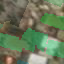

In [16]:
ind = 11

image = image_tensors[ind]
mask = masks_binary[ind]
annotated_tensor = draw_segmentation_masks( 
    image=(image*255).to(dtype=torch.uint8), 
    masks=mask, 
    alpha=0.3,
)

tensor_to_pil(annotated_tensor)

## 3. Create bounding boxes with labels

In [17]:
def mask_to_box(masks_transformed):
    boxes = []
    labels = []

    for mask in masks_transformed:
        labels_mask = []
        standing_list = []
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]

        if len(obj_ids) == 1:
            standing = mask == obj_ids[:, None, None]
            standing_tensor = standing.int()
            
            
        elif len(obj_ids) == 2:
            separate_masks = mask == obj_ids[:, None, None]
            standing, collapsed = torch.split(separate_masks, 1, dim=0)
            standing_tensor, collapsed_tensor = standing.int(), collapsed.int()

        ### standing buildings
        standing_np, count = ski.measure.label(standing_tensor, connectivity=1, return_num=True)
        standing_test = torch.from_numpy(np.array(standing_np))
        standing_obj_ids = torch.unique(standing_test)
        standing_obj_ids = standing_obj_ids[1:]
        
        standing_boolean = standing_test == standing_obj_ids[:, None, None]
        standing_boxes_test = masks_to_boxes(standing_boolean)
        
        #cull mini boxes
        
        cull_list = []
        for num, i in enumerate(standing_boxes_test):
            result_x = i[0] - i[2]
            result_y = i[1] - i[3]
            if result_x == 0 or result_y == 0:
                cull_list.append(num)
            
        cull_list.sort(reverse=True)
        
        for index in cull_list:
            standing_boxes_test = torch.cat((standing_boxes_test[:index], standing_boxes_test[index + 1:]))
        
        # output: boxes and labels
        label1 = 1
        standing_list = [(row) for row in standing_boxes_test]

        for i in range(len(standing_list)):
            labels_mask.append(label1)
            
        ### collapsed buildings
        collapsed_list = []

        if len(obj_ids) == 2:  # Need to handle this condition
            collapsed_np, count = ski.measure.label(collapsed_tensor, connectivity=1, return_num=True)
            
            collapsed_test = torch.from_numpy(np.array(collapsed_np))
            
            collapsed_obj_ids = torch.unique(collapsed_test)
            collapsed_obj_ids = collapsed_obj_ids[1:]
            
            collapsed_boolean = collapsed_test == collapsed_obj_ids[:, None, None]
            collapsed_boxes_test = masks_to_boxes(collapsed_boolean)
            
            #cull mini boxes
        
            cull_list = []
            for num, i in enumerate(collapsed_boxes_test):
                result_x = i[0] - i[2]
                result_y = i[1] - i[3]
                if result_x == 0 or result_y == 0:
                    cull_list.append(num)
            
            cull_list.sort(reverse=True)
        
            for index in cull_list:
                collapsed_boxes_test = torch.cat((collapsed_boxes_test[:index], collapsed_boxes_test[index + 1:]))
            
            # output: boxes and labels

            label2 = 2
            collapsed_list = [(row) for row in collapsed_boxes_test]
            for i in range(len(collapsed_list)):
                labels_mask.append(label2)
                
                

        both_lists = standing_list + collapsed_list
        boxes.append(both_lists)

        boxes_int64 = []

        for box in boxes:
            tensor_box = torch.from_numpy(np.array(box)).to(torch.int64)
            boxes_int64.append(tensor_box)

        labels.append(labels_mask)

        labels_int64 = []
        for label in labels:
            tensor_label = torch.from_numpy(np.array(label)).to(torch.int64)
            labels_int64.append(tensor_label)

    return boxes_int64, labels_int64


In [18]:
# takes masks_transformed not masks_binary
labeled_boxes = mask_to_box(masks_transformed)
boxes, labels = labeled_boxes
ind = 105
print(boxes[ind], labels[ind])

tensor([[ 4, 38, 27, 61]]) tensor([2])


## 4. Make dataset

In [19]:
def test_train_split(objects):
    split_index = int(0.79 * len(objects))
    # Split the list
    train_dataset = objects[:split_index]
    test_dataset = objects[split_index:]
    return train_dataset, test_dataset

train_images, test_images = test_train_split(image_tensors)
train_masks, test_masks = test_train_split(masks_binary)
train_boxes, test_boxes = test_train_split(boxes)
train_labels, test_labels = test_train_split(labels)
train_ids, test_ids = test_train_split(image_ids)

In [20]:
class CustData(torch.utils.data.Dataset):
    def __init__(self, images, masks, boxes, labels, image_ids):
        self.images = images
        self.masks = masks
        self.boxes = boxes
        self.labels = labels
        self.image_ids = image_ids
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        
        # Retrieve the key for the image at the specified index
        image_ids = self.image_ids[index]
        mask = self.masks[index]
        box = self.boxes[index]
        label = self.labels[index]
        image = self.images[index]       
        
        
        return image, {'boxes': box,'labels': label, 'masks': mask} 

In [21]:
train_dataset = CustData(train_images, train_masks, train_boxes, train_labels, train_ids)
test_dataset = CustData(test_images, test_masks, test_boxes, test_labels, test_ids)
len(train_dataset)

90

In [22]:
index = 30
print(train_dataset[index][1]["boxes"], train_dataset[index][1]["labels"])

tensor([[ 6,  0, 51, 33],
        [37,  0, 47,  2],
        [ 0, 24, 17, 42],
        [ 0, 42, 31, 63],
        [48, 55, 63, 63],
        [50, 15, 63, 57]]) tensor([1, 1, 1, 1, 1, 2])


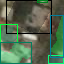

In [23]:
dataset_sample = train_dataset[index]

# Get colors for dataset sample

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks( 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    masks=dataset_sample[1]['masks'], 
    alpha=0.3,
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'],
)

tensor_to_pil(annotated_tensor)

## 5. Make Dataloaders

In [24]:
# Set the training batch size
bs = 2

# Set the number of worker processes for loading data ! multiprocessing.cpu_count()//2 !
num_workers = 0

# collatr function specifies the way data sticks together in a batch
def collate_fn(batch):
    return tuple(zip(*batch))

def custom_collate(data):
  return data

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'collate_fn': custom_collate,
    'pin_memory': True,
    'pin_memory_device': device
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
test_dataloader = DataLoader(test_dataset, **data_loader_params)


pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(test_dataloader)}
).to_frame().style.hide(axis='columns')


next(iter(train_dataloader))

[[tensor([[[0.4549, 0.4549, 0.4863,  ..., 0.2902, 0.2824, 0.2784],
           [0.6039, 0.5922, 0.5804,  ..., 0.2902, 0.2745, 0.2706],
           [0.6353, 0.6235, 0.6078,  ..., 0.2902, 0.2745, 0.2667],
           ...,
           [0.3294, 0.3255, 0.3373,  ..., 0.3843, 0.4118, 0.4471],
           [0.3294, 0.3294, 0.3333,  ..., 0.3765, 0.3961, 0.4235],
           [0.3333, 0.3255, 0.3216,  ..., 0.3686, 0.3725, 0.3843]],
  
          [[0.4431, 0.4431, 0.4745,  ..., 0.3333, 0.3373, 0.3373],
           [0.5922, 0.5804, 0.5686,  ..., 0.3333, 0.3294, 0.3294],
           [0.6235, 0.6118, 0.5961,  ..., 0.3333, 0.3294, 0.3216],
           ...,
           [0.3373, 0.3373, 0.3490,  ..., 0.4000, 0.4275, 0.4627],
           [0.3412, 0.3412, 0.3529,  ..., 0.3922, 0.4118, 0.4392],
           [0.3451, 0.3373, 0.3412,  ..., 0.3804, 0.3843, 0.4000]],
  
          [[0.3686, 0.3686, 0.4078,  ..., 0.2078, 0.2078, 0.2078],
           [0.5176, 0.5059, 0.5020,  ..., 0.2078, 0.2000, 0.2000],
           [0.5490, 0.

## 7. Loading the Mask R-CNN Model

In [25]:
classes = 3

# Initialize a Mask R-CNN model with pretrained weights
model = torchvision.models.detection.maskrcnn_resnet50_fpn()


In [26]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [27]:
classes = 3

# Initialize a Mask R-CNN model with pretrained weights
model = torchvision.models.detection.maskrcnn_resnet50_fpn()

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=classes)

hidden_layer = 256

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=hidden_layer, num_classes=classes)

In [28]:
# Set the model's device and data type
model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn'

### 7.2 Summarize the model

In [29]:
def model_summarize(model):

    test_inp = torch.randn(1, 3, 256, 256).to(device)

    summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")

    # # Filter the summary to only contain Conv2d layers and the model
    summary_df = summary_df[summary_df.index == 0]

    return summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

model_summarize(model)

C:\Users\kubaw\miniforge3\envs\pytorch-env\lib\site-packages\torchtnt\utils\module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs
0,MaskRCNN,43.9 M,43.7 M,176 M,185 G


## 8. Fine-tuning the model

### 8.1 Define the training loop

### 8.2 Set the Model Checkpoint Path

In [30]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

\pytorch-buildings-maskrcnn\2023-10-18_16-04-22\maskrcnn_resnet50_fpn.pth


### 8.3 Configure the Training Parameters

In [31]:
# Learning rate for the model

# Number of training epochs
params = [p for p in model.parameters() if p.requires_grad]

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)


## 9. Train!

In [32]:
all_train_losses = []
all_val_losses = []


flag = False
epochs = 10

for epoch in range(epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0
    
    # put the model into training mode
    model.train()
    
    print("im here")
    
    
    #TRAINING LOOP
    
    # dt is for training the dataloader, 
    for i , dt in enumerate(train_dataloader):
        
        #imgs to device
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        
        # targets list will contain dictionaries where the values from targ are moved to a specified device
            # Iterates over each element (t) in the targ list
            # Creates a dictionary by iterating over the key-value pairs in t 
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        
        # CALCULATE LOSS: for boxes, masks and the region proposal network
        loss = model(imgs, targets)
        
        # flag ensures that the initial parameters of the loss are only printed once
        if not flag:
            print(loss)
            flag = True
        
        # sum all the losses
        losses = sum([l for l in loss.values()])
        
        # add the losses into train_epoch_loss for one epoch
        train_epoch_loss += losses.cpu().detach().numpy()
        
        # optimizer zero
        optimizer.zero_grad()
        
        # backpropagation
        losses.backward()
        
        # optimize weights and biases
        optimizer.step()
        
    # summrize all losses
    all_train_losses.append(train_epoch_loss)
    
    #VALIDATION LOOP
    
    # put model into inference mode
    with torch.no_grad():
        
        for j , dt in enumerate(test_dataloader):
            
            #imgs to device
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            
            # targets list will contain dictionaries where the values from targ are moved to a specified device
                # Iterates over each element (t) in the targ list
                # Creates a dictionary by iterating over the key-value pairs in t     
            targ = [dt[0][1] , dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            
            # CALCULATE LOSS: for boxes, masks and the region proposal network
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            
            # add the losses into val_epoch_loss for one epoch
            val_epoch_loss += losses.cpu().detach().numpy()
            
        # summrize all losses
        all_val_losses.append(val_epoch_loss)
      
    
    #print results for on epoch
    print(f"epoch: {epoch}    training loss {train_epoch_loss}    validation loss: {val_epoch_loss}")

im here
{'loss_classifier': tensor(1.0826, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0488, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(1.5802, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6897, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0182, device='cuda:0', grad_fn=<DivBackward0>)}
epoch: 0    training loss 76.76234710216522    validation loss: 17.161327123641968
im here


KeyboardInterrupt: 

In [40]:
plt.plot(all_train_losses)

In [39]:
all_val_losses

[16.176132678985596,
 16.297901332378387,
 16.567949533462524,
 15.741186559200287,
 16.590915620326996,
 15.951047480106354,
 16.021022260189056,
 15.419067978858948,
 15.376284122467041,
 16.46754091978073]